In [ ]:
!wget https://files.fast.ai/data/examples/dogscats.tgz

--2021-01-10 17:09:33--  https://files.fast.ai/data/examples/dogscats.tgz
Resolving files.fast.ai (files.fast.ai)... 172.67.69.159, 104.26.2.19, 104.26.3.19, ...
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839285364 (800M) [application/x-gtar-compressed]
Saving to: ‘dogscats.tgz’

dogscats.tgz        100%[===================>] 800.40M  69.2MB/s    in 13s     

2021-01-10 17:09:47 (60.8 MB/s) - ‘dogscats.tgz’ saved [839285364/839285364]



In [ ]:
!tar -zxvf dogscats.tgz

Streaming output truncated to the last 5000 lines.
dogscats/test1/4634.jpg
dogscats/test1/5841.jpg
dogscats/test1/4590.jpg
dogscats/test1/7251.jpg
dogscats/test1/1014.jpg
dogscats/test1/3899.jpg
dogscats/test1/8220.jpg
dogscats/test1/11600.jpg
dogscats/test1/1223.jpg
dogscats/test1/786.jpg
dogscats/test1/8842.jpg
dogscats/test1/7416.jpg
dogscats/test1/3641.jpg
dogscats/test1/9389.jpg
dogscats/test1/4093.jpg
dogscats/test1/883.jpg
dogscats/test1/5787.jpg
dogscats/test1/12059.jpg
dogscats/test1/10965.jpg
dogscats/test1/7406.jpg
dogscats/test1/5904.jpg
dogscats/test1/9852.jpg
dogscats/test1/5532.jpg
dogscats/test1/7344.jpg
dogscats/test1/1327.jpg
dogscats/test1/2836.jpg
dogscats/test1/6135.jpg
dogscats/test1/1938.jpg
dogscats/test1/6757.jpg
dogscats/test1/4972.jpg
dogscats/test1/8333.jpg
dogscats/test1/990.jpg
dogscats/test1/1936.jpg
dogscats/test1/3790.jpg
dogscats/test1/7500.jpg
dogscats/test1/1473.jpg
dogscats/test1/459.jpg
dogscats/test1/5137.jpg
dogscats/test1/4541.jpg
dogscats/test1

In [ ]:

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau

import h5py
from sklearn.utils import shuffle

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
path = '/content/dogscats/'
#sample_path = '/output/dogscats/sample'
batch_size = 32


In [ ]:
def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(path+'train', image_size, shuffle=False, 
                                              batch_size=batch_size)
    valid_generator = gen.flow_from_directory(path+'valid', image_size, shuffle=False, 
                                              batch_size=batch_size)
    test_generator = gen.flow_from_directory(path+'test', image_size, shuffle=False, 
                                             batch_size=batch_size, class_mode=None)

    train = model.predict_generator(train_generator, train_generator.samples)
    valid = model.predict_generator(valid_generator, valid_generator.samples)
    test = model.predict_generator(test_generator, test_generator.samples)
    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("valid", data=valid)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)
        h.create_dataset("val_label", data=valid_generator.classes)

In [ ]:
%time write_gap(ResNet50, (224, 224))

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


CPU times: user 2h 43min 43s, sys: 1min 48s, total: 2h 45min 31s
Wall time: 1h 25min 26s


In [ ]:
X_train = []
X_valid = []
X_test = []

import numpy as np

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

In [ ]:
#Adam Optimizer
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_adam = Model(input_tensor, x)
model_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_adam = model_adam.fit(X_train, y_train, batch_size=batch_size*2, 
               epochs=300, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

In [ ]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_sgd = Model(input_tensor, x)
model_sgd.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
hist_sgd = model_sgd.fit(X_train, y_train, batch_size=batch_size*2, 
              epochs=300, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

In [ ]:
#Adadelta
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_adadelta = Model(input_tensor, x)
model_adadelta.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
hist_adadelta = model_adadelta.fit(X_train, y_train, batch_size=batch_size*2, 
              epochs=300, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

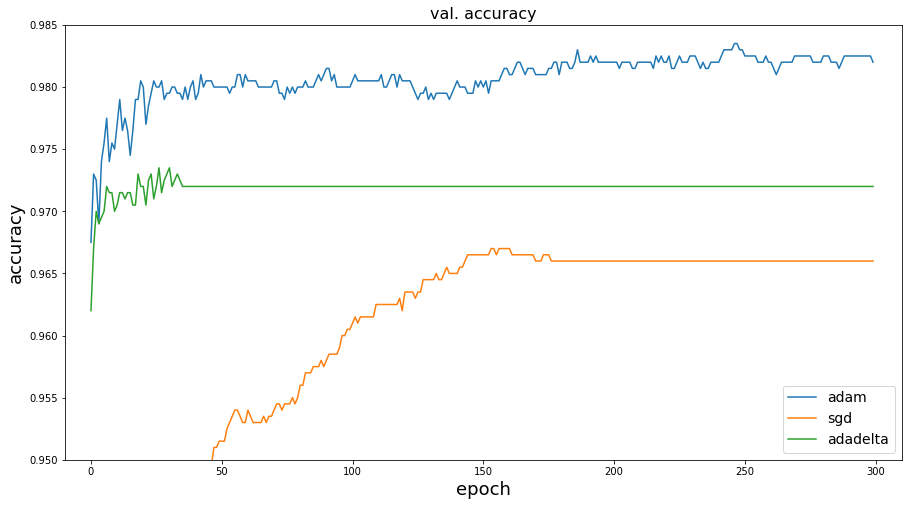

In [112]:
plt.figure(figsize=(15, 8))  
plt.axis((-10,310,0.95,0.985))

plt.plot(hist_adam.history['val_accuracy'])
plt.plot(hist_adadelta.history['val_accuracy'])
plt.plot(hist_sgd.history['val_accuracy'])
plt.title('val. accuracy', fontsize = 16)  
plt.ylabel('accuracy', fontsize = 18)  
plt.xlabel('epoch', fontsize = 18)  
plt.legend(['adam', 'sgd', 'adadelta'], loc='lower right', fontsize = 14)  

plt.show()

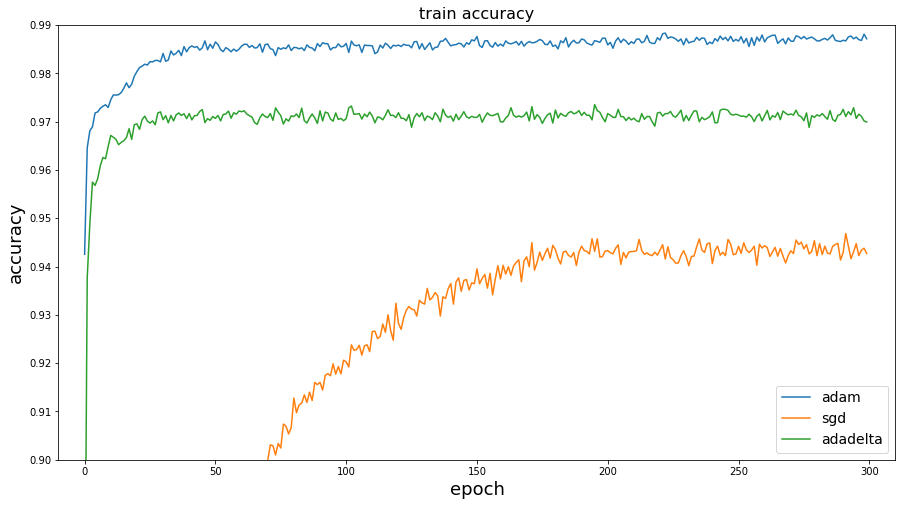

In [111]:
plt.figure(figsize=(15, 8))  
plt.axis((-10,310,0.9,0.99))

plt.plot(hist_adam.history['accuracy'])
plt.plot(hist_adadelta.history['accuracy'])
plt.plot(hist_sgd.history['accuracy'])
plt.title('train accuracy', fontsize = 16)  
plt.ylabel('accuracy', fontsize = 18)  
plt.xlabel('epoch', fontsize = 18)   
plt.legend(['adam', 'sgd', 'adadelta'], loc='lower right', fontsize = 14)  

plt.show()




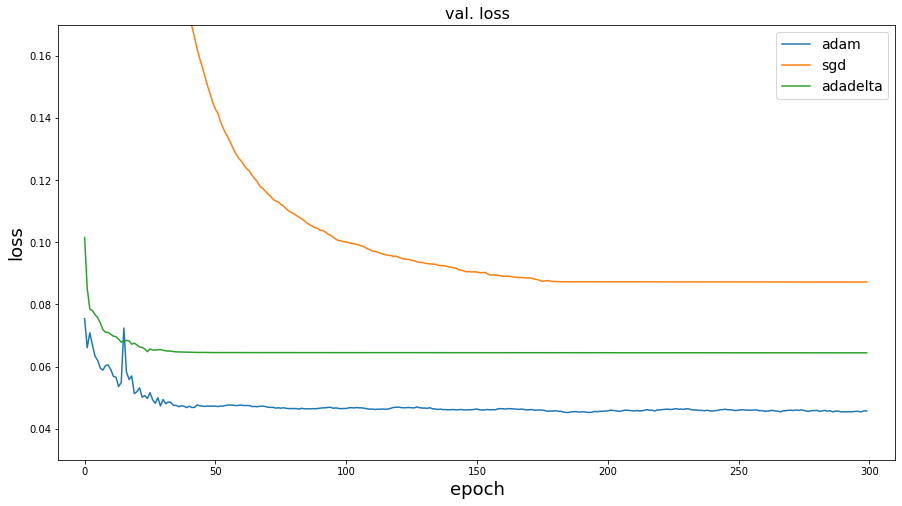

In [110]:
plt.figure(figsize=(15, 8))  
plt.axis((-10,310,0.03,0.17))

plt.plot(hist_adam.history['val_loss'])
plt.plot(hist_adadelta.history['val_loss'])
plt.plot(hist_sgd.history['val_loss'])
plt.title('val. loss', fontsize = 16)  
plt.ylabel('loss', fontsize = 18)  
plt.xlabel('epoch', fontsize = 18)  
plt.legend(['adam', 'sgd', 'adadelta'], loc='upper right', fontsize = 14)  

plt.show()

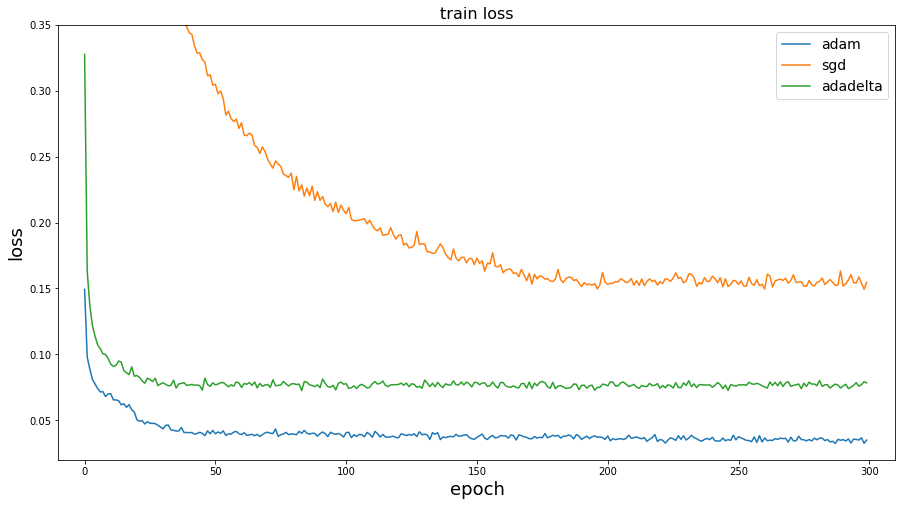

In [109]:
plt.figure(figsize=(15, 8))  
plt.axis((-10,310,0.02,0.35))

plt.plot(hist_adam.history['loss'])
plt.plot(hist_adadelta.history['loss'])
plt.plot(hist_sgd.history['loss'])
plt.title('train loss', fontsize = 16)  
plt.ylabel('loss', fontsize = 18)  
plt.xlabel('epoch', fontsize = 18)  
plt.legend(['adam', 'sgd', 'adadelta'], loc='upper right', fontsize = 14)  

plt.show()

In [ ]:
#Nesterov

from keras import optimizers
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_sgdnes = Model(input_tensor, x)
sgdnes = optimizers.SGD(nesterov=True)
model_sgdnes.compile(optimizer=sgdnes, loss='binary_crossentropy', metrics=['accuracy'])
hist_sgdnes = model_sgdnes.fit(X_train, y_train, batch_size=batch_size*2, 
              epochs=300, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

In [ ]:
#Momentum
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
sgdop = optimizers.SGD( momentum=0.9)
model_sgdmo = Model(input_tensor, x)
model_sgdmo.compile(optimizer=sgdop, loss='binary_crossentropy', metrics=['accuracy'])
hist_sgdmo = model_sgdmo.fit(X_train, y_train, batch_size=batch_size*2, 
              epochs=300, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

In [ ]:
#nesterov+momentum
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

sgdopnes = optimizers.SGD( momentum=0.9, nesterov=True)
model_sgdmones = Model(input_tensor, x)
model_sgdmones.compile(optimizer=sgdopnes, loss='binary_crossentropy', metrics=['accuracy'])
hist_sgdmones = model_sgdmones.fit(X_train, y_train, batch_size=batch_size*2, 
              epochs=300, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

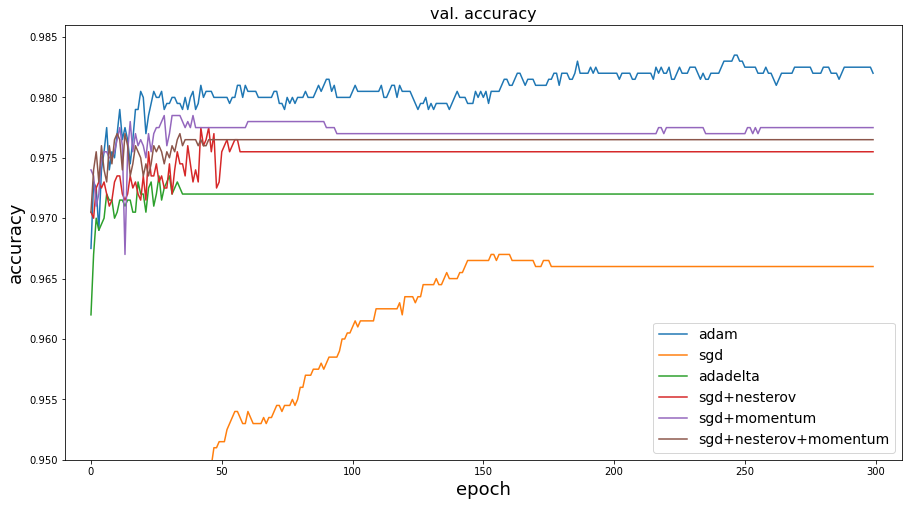

In [103]:
plt.figure(figsize=(15, 8))  
plt.axis((-10,310,0.95,0.986))

plt.plot(hist_adam.history['val_accuracy'])
plt.plot(hist_adadelta.history['val_accuracy'])

plt.plot(hist_sgd.history['val_accuracy'])
plt.plot(hist_sgdnes.history['val_accuracy'])
plt.plot(hist_sgdmo.history['val_accuracy'])
plt.plot(hist_sgdmones.history['val_accuracy'])
plt.title('val. accuracy', fontsize = 16)  
plt.ylabel('accuracy', fontsize = 18)  
plt.xlabel('epoch', fontsize = 18)  
plt.legend([ 'adam', 'sgd', 'adadelta', 'sgd+nesterov', 'sgd+momentum', 'sgd+nesterov+momentum'], loc='lower right', fontsize = 14)  

plt.show()

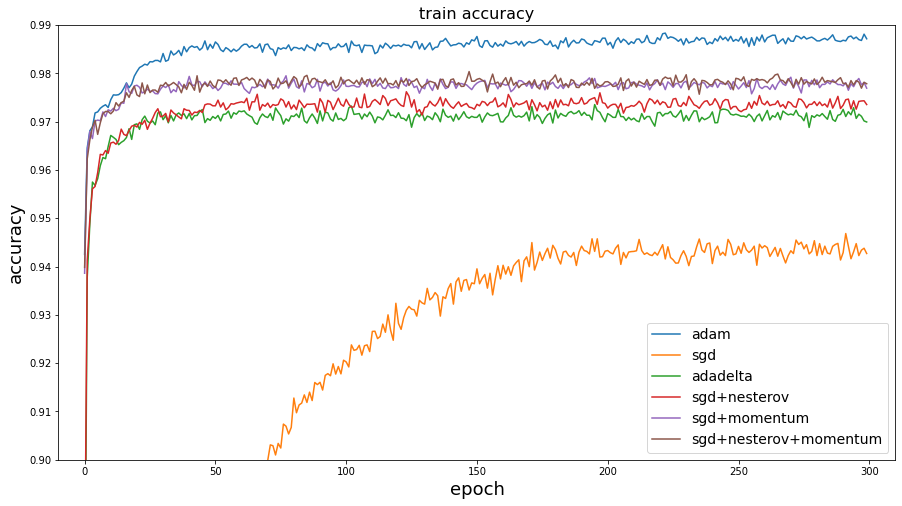

In [106]:
plt.figure(figsize=(15, 8))  
plt.axis((-10,310,0.90,0.99))

plt.plot(hist_adam.history['accuracy'])
plt.plot(hist_adadelta.history['accuracy'])
plt.plot(hist_sgd.history['accuracy'])
plt.plot(hist_sgdnes.history['accuracy'])
plt.plot(hist_sgdmo.history['accuracy'])
plt.plot(hist_sgdmones.history['accuracy'])
plt.title('train accuracy', fontsize = 16)  
plt.ylabel('accuracy', fontsize =18 )  
plt.xlabel('epoch', fontsize = 18)  
plt.legend([ 'adam', 'sgd', 'adadelta', 'sgd+nesterov', 'sgd+momentum', 'sgd+nesterov+momentum'], loc='lower right', fontsize = 14)  

plt.show()

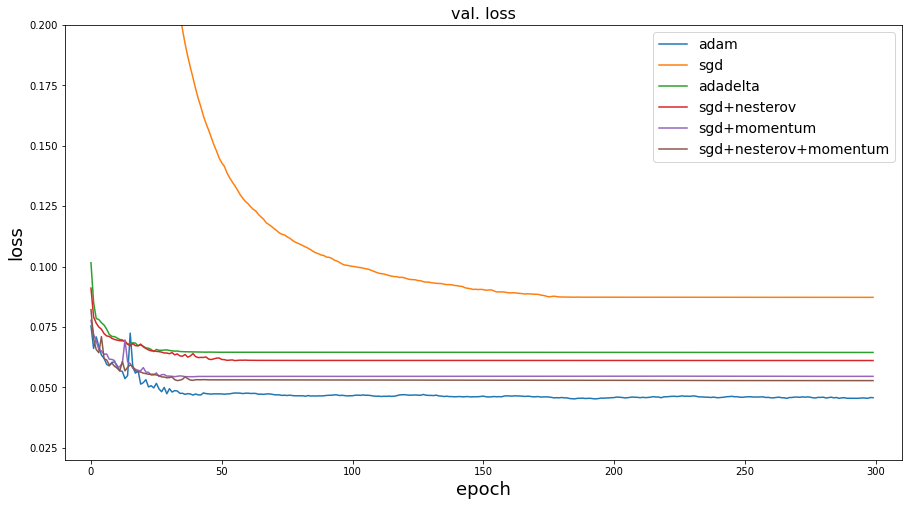

In [107]:
plt.figure(figsize=(15, 8))  
plt.axis((-10,310,0.02,0.2))

plt.plot(hist_adam.history['val_loss'])
plt.plot(hist_adadelta.history['val_loss'])
plt.plot(hist_sgd.history['val_loss'])
plt.plot(hist_sgdnes.history['val_loss'])
plt.plot(hist_sgdmo.history['val_loss'])
plt.plot(hist_sgdmones.history['val_loss'])
plt.title('val. loss', fontsize = 16)  
plt.ylabel('loss', fontsize = 18)  
plt.xlabel('epoch', fontsize = 18)  
plt.legend([ 'adam', 'sgd', 'adadelta', 'sgd+nesterov', 'sgd+momentum', 'sgd+nesterov+momentum'], loc='upper right', fontsize = 14)  

plt.show()

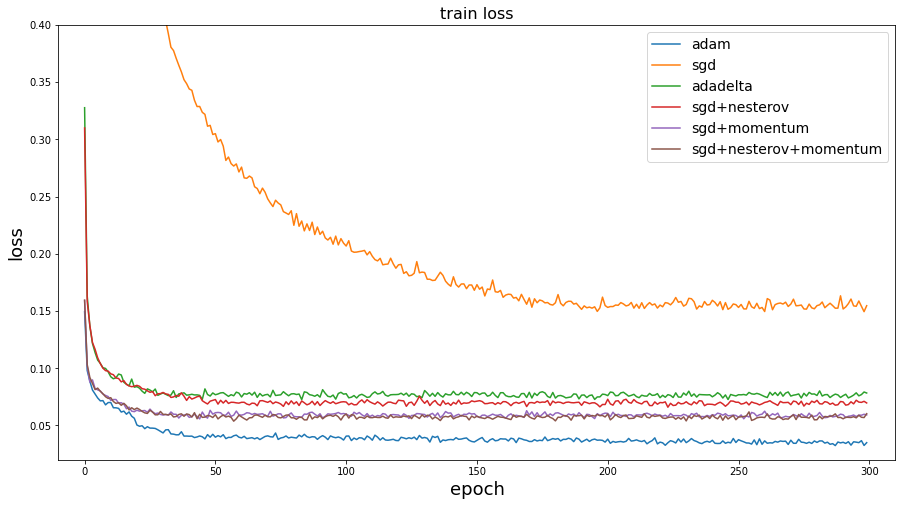

In [108]:
plt.figure(figsize=(15, 8))  
plt.axis((-10,310,0.02,0.4))

plt.plot(hist_adam.history['loss'])
plt.plot(hist_adadelta.history['loss'])
plt.plot(hist_sgd.history['loss'])
plt.plot(hist_sgdnes.history['loss'])
plt.plot(hist_sgdmo.history['loss'])
plt.plot(hist_sgdmones.history['loss'])
plt.title('train loss', fontsize = 16)  
plt.ylabel('loss',fontsize =18)  
plt.xlabel('epoch',fontsize =18)  
plt.legend([ 'adam', 'sgd', 'adadelta', 'sgd+nesterov', 'sgd+momentum', 'sgd+nesterov+momentum'], loc='upper right',fontsize =14)  

plt.show()